# Model trained on dataset B2

In [9]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Data loading

In [2]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train = PetDataset('annotations_aug/annotations_train_B2.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid_B2.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test_B2.csv','img_augmented_processed/', transform = trans)

train_loader = DataLoader(train,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


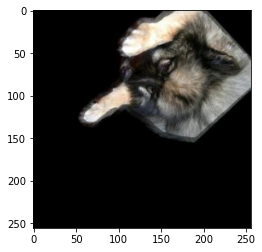

In [3]:
train_b2_img, train_b2_label = next(iter(train_loader))
print('shape of training batch (images): {}'.format(train_b2_img.shape))
print('shape of training batch (labels): {}'.format(train_b2_label.shape))
plt.imshow(train_b2_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

### Helper functions

In [4]:
def model_dict(model,iteration,current_train_accuracy,current_valid_accuracy):
    """
    Returns a dictionary with a deep copy of the model in its current state and the associated accuracy metrics.
    """
    
    return {'current_model': copy.deepcopy(model), 'current_iter':copy.deepcopy(iteration), 'current_train_acc':copy.deepcopy(current_train_accuracy), 'current_valid_acc':copy.deepcopy(current_valid_accuracy)}

def add_to_saved_models(saved_models,length,model,iteration,current_train_accuracy,current_valid_accuracy):
    """
    saved_models is a list of specified length where we save the deep copies of the model at different training stages with the best validation accuracies.
    
    This function adds a dictionary created by model_dict(...) defined above either if the list of saved_models is not full yet, or if the current version of the model is better than the worst one already saved in the list.
    """
    
    dic = model_dict(model,iteration,current_train_accuracy,current_valid_accuracy)
    
    if len(saved_models)<length:
        saved_models.append(dic)
    else:
        valid_acc_list = [dictionary['current_valid_acc'] for dictionary in saved_models]
        min_valid_acc = min(valid_acc_list)
        min_valid_index = valid_acc_list.index(min_valid_acc)
        
        if dic['current_valid_acc'] > min_valid_acc:
            saved_models[min_valid_index] = dic

### Model and training

In [6]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    

model = PetCNN6()
loss_function = nn.NLLLoss()

    
saved_models = []

learning_rate = 0.001
wt_decay = 0.0003
lr_decay = 0.75    

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=wt_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=lr_decay)

num_epochs = 40

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()


for epoch in range(num_epochs):
    for images, labels in train_loader:
        model.train()
        out = model(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%25==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 25 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    
            
            
            if epoch>0:     
                
                model.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=1024,shuffle=True)  
                    images_c, labels_c = next(iter(train_part))
                    train_out = model(images_c.float())    
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/1024
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)
                    
                    if current_valid_accuracy > 0.53:
                        add_to_saved_models(saved_models,5,model,iteration,current_train_accuracy,current_valid_accuracy)
                        

                
            start = time.time()
            
    scheduler.step()
                

        

    


Epoch:0
Iteration:25
Time taken for the last 25 iterations: 38.53897738456726
Current learning rate:0.001
Epoch:0
Iteration:50
Time taken for the last 25 iterations: 40.42424964904785
Current learning rate:0.001
Epoch:0
Iteration:75
Time taken for the last 25 iterations: 38.92998147010803
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 25 iterations: 38.70585060119629
Current learning rate:0.001
Epoch:0
Iteration:125
Time taken for the last 25 iterations: 37.687315464019775
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 25 iterations: 37.69725489616394
Current learning rate:0.001
Epoch:0
Iteration:175
Time taken for the last 25 iterations: 37.99065375328064
Current learning rate:0.001
Epoch:0
Iteration:200
Time taken for the last 25 iterations: 36.600921630859375
Current learning rate:0.001
Epoch:0
Iteration:225
Time taken for the last 25 iterations: 37.79105830192566
Current learning rate:0.001
Epoch:0
Iteration:250
Time taken for t

Current validation loss:2.320007801055908
Current validation accuracy:0.33541667461395264
Epoch:3
Iteration:950
Time taken for the last 25 iterations: 32.51327657699585
Current learning rate:0.00075
Current training loss:2.18707537651062
Current training accuracy:0.4189453125
Current validation loss:2.1040194034576416
Current validation accuracy:0.39270833134651184
Epoch:3
Iteration:975
Time taken for the last 25 iterations: 31.578229427337646
Current learning rate:0.00075
Current training loss:2.1575911045074463
Current training accuracy:0.380859375
Current validation loss:2.130932092666626
Current validation accuracy:0.3916666805744171
Epoch:3
Iteration:1000
Time taken for the last 25 iterations: 36.63015580177307
Current learning rate:0.00075
Current training loss:2.1856603622436523
Current training accuracy:0.373046875
Current validation loss:2.1860320568084717
Current validation accuracy:0.3854166567325592
Epoch:3
Iteration:1025
Time taken for the last 25 iterations: 35.7764499187

Epoch:5
Iteration:1650
Time taken for the last 25 iterations: 30.22030782699585
Current learning rate:0.0005625000000000001
Current training loss:1.557260513305664
Current training accuracy:0.5908203125
Current validation loss:1.7811927795410156
Current validation accuracy:0.47083333134651184
Epoch:6
Iteration:1675
Time taken for the last 25 iterations: 30.51121211051941
Current learning rate:0.00042187500000000005
Current training loss:1.4924674034118652
Current training accuracy:0.595703125
Current validation loss:1.7700443267822266
Current validation accuracy:0.47187501192092896
Epoch:6
Iteration:1700
Time taken for the last 25 iterations: 28.195993661880493
Current learning rate:0.00042187500000000005
Current training loss:1.589072823524475
Current training accuracy:0.5791015625
Current validation loss:1.8031424283981323
Current validation accuracy:0.46041667461395264
Epoch:6
Iteration:1725
Time taken for the last 25 iterations: 29.404590845108032
Current learning rate:0.0004218750

Epoch:8
Iteration:2350
Time taken for the last 25 iterations: 26.55054545402527
Current learning rate:0.00031640625000000006
Current training loss:1.078715443611145
Current training accuracy:0.751953125
Current validation loss:1.6338452100753784
Current validation accuracy:0.5249999761581421
Epoch:8
Iteration:2375
Time taken for the last 25 iterations: 26.399592876434326
Current learning rate:0.00031640625000000006
Current training loss:1.1610416173934937
Current training accuracy:0.6845703125
Current validation loss:1.7026245594024658
Current validation accuracy:0.512499988079071
Epoch:8
Iteration:2400
Time taken for the last 25 iterations: 26.80104374885559
Current learning rate:0.00031640625000000006
Current training loss:0.9535977840423584
Current training accuracy:0.7685546875
Current validation loss:1.5694111585617065
Current validation accuracy:0.5364583134651184
Epoch:8
Iteration:2425
Time taken for the last 25 iterations: 26.116168975830078
Current learning rate:0.000316406250

Epoch:11
Iteration:3050
Time taken for the last 25 iterations: 25.39574956893921
Current learning rate:0.00023730468750000005
Current training loss:0.6482177376747131
Current training accuracy:0.875
Current validation loss:1.5623022317886353
Current validation accuracy:0.5322916507720947
Epoch:11
Iteration:3075
Time taken for the last 25 iterations: 25.44768500328064
Current learning rate:0.00023730468750000005
Current training loss:0.6074559092521667
Current training accuracy:0.8818359375
Current validation loss:1.600713849067688
Current validation accuracy:0.5406249761581421
Epoch:11
Iteration:3100
Time taken for the last 25 iterations: 25.941156148910522
Current learning rate:0.00023730468750000005
Current training loss:0.6825637221336365
Current training accuracy:0.861328125
Current validation loss:1.58271324634552
Current validation accuracy:0.543749988079071
Epoch:11
Iteration:3125
Time taken for the last 25 iterations: 25.202216386795044
Current learning rate:0.00023730468750000

Epoch:13
Iteration:3750
Time taken for the last 25 iterations: 24.576842784881592
Current learning rate:0.00017797851562500002
Current training loss:0.519051194190979
Current training accuracy:0.9091796875
Current validation loss:1.611906886100769
Current validation accuracy:0.5395833253860474
Epoch:13
Iteration:3775
Time taken for the last 25 iterations: 24.44435477256775
Current learning rate:0.00017797851562500002
Current training loss:0.4780806601047516
Current training accuracy:0.919921875
Current validation loss:1.5558909177780151
Current validation accuracy:0.5489583611488342
Epoch:13
Iteration:3800
Time taken for the last 25 iterations: 24.23652672767639
Current learning rate:0.00017797851562500002
Current training loss:0.4523536264896393
Current training accuracy:0.9130859375
Current validation loss:1.6171311140060425
Current validation accuracy:0.5395833253860474
Epoch:13
Iteration:3825
Time taken for the last 25 iterations: 24.89940643310547
Current learning rate:0.000177978

Epoch:16
Iteration:4450
Time taken for the last 25 iterations: 25.01879048347473
Current learning rate:0.00010011291503906251
Current training loss:0.3142213523387909
Current training accuracy:0.9599609375
Current validation loss:1.5766929388046265
Current validation accuracy:0.550000011920929
Epoch:16
Iteration:4475
Time taken for the last 25 iterations: 25.688642978668213
Current learning rate:0.00010011291503906251
Current training loss:0.3054479658603668
Current training accuracy:0.9609375
Current validation loss:1.5763875246047974
Current validation accuracy:0.550000011920929
Epoch:16
Iteration:4500
Time taken for the last 25 iterations: 25.26956343650818
Current learning rate:0.00010011291503906251
Current training loss:0.3144400119781494
Current training accuracy:0.95703125
Current validation loss:1.5811171531677246
Current validation accuracy:0.5520833134651184
Epoch:16
Iteration:4525
Time taken for the last 25 iterations: 23.557661056518555
Current learning rate:0.000100112915

Epoch:18
Iteration:5150
Time taken for the last 25 iterations: 26.388049125671387
Current learning rate:7.508468627929689e-05
Current training loss:0.260934978723526
Current training accuracy:0.97265625
Current validation loss:1.6024346351623535
Current validation accuracy:0.5427083373069763
Epoch:18
Iteration:5175
Time taken for the last 25 iterations: 27.518481969833374
Current learning rate:7.508468627929689e-05
Current training loss:0.25753313302993774
Current training accuracy:0.9638671875
Current validation loss:1.5972614288330078
Current validation accuracy:0.5510416626930237
Epoch:18
Iteration:5200
Time taken for the last 25 iterations: 26.764892578125
Current learning rate:7.508468627929689e-05
Current training loss:0.26838427782058716
Current training accuracy:0.96875
Current validation loss:1.6108402013778687
Current validation accuracy:0.5479166507720947
Epoch:18
Iteration:5225
Time taken for the last 25 iterations: 27.32339072227478
Current learning rate:7.508468627929689e

Epoch:21
Iteration:5850
Time taken for the last 25 iterations: 28.3488986492157
Current learning rate:5.631351470947266e-05
Current training loss:0.2093435674905777
Current training accuracy:0.98046875
Current validation loss:1.6359888315200806
Current validation accuracy:0.546875
Epoch:21
Iteration:5875
Time taken for the last 25 iterations: 27.2105073928833
Current learning rate:5.631351470947266e-05
Current training loss:0.23364940285682678
Current training accuracy:0.9658203125
Current validation loss:1.6124114990234375
Current validation accuracy:0.5552083253860474
Epoch:21
Iteration:5900
Time taken for the last 25 iterations: 27.857051849365234
Current learning rate:5.631351470947266e-05
Current training loss:0.18906696140766144
Current training accuracy:0.9794921875
Current validation loss:1.6140732765197754
Current validation accuracy:0.550000011920929
Epoch:21
Iteration:5925
Time taken for the last 25 iterations: 26.06505012512207
Current learning rate:5.631351470947266e-05
Cu

Epoch:23
Iteration:6550
Time taken for the last 25 iterations: 28.472168684005737
Current learning rate:4.22351360321045e-05
Current training loss:0.1868508756160736
Current training accuracy:0.978515625
Current validation loss:1.6408566236495972
Current validation accuracy:0.5406249761581421
Epoch:23
Iteration:6575
Time taken for the last 25 iterations: 28.10877561569214
Current learning rate:4.22351360321045e-05
Current training loss:0.2052248865365982
Current training accuracy:0.9697265625
Current validation loss:1.658737063407898
Current validation accuracy:0.5458333492279053
Epoch:23
Iteration:6600
Time taken for the last 25 iterations: 28.504061698913574
Current learning rate:4.22351360321045e-05
Current training loss:0.19749683141708374
Current training accuracy:0.978515625
Current validation loss:1.6522786617279053
Current validation accuracy:0.5406249761581421
Epoch:24
Iteration:6625
Time taken for the last 25 iterations: 27.489517211914062
Current learning rate:3.167635202407

Epoch:26
Iteration:7250
Time taken for the last 25 iterations: 28.472934007644653
Current learning rate:2.3757264018058778e-05
Current training loss:0.18973897397518158
Current training accuracy:0.978515625
Current validation loss:1.651682734489441
Current validation accuracy:0.543749988079071
Epoch:26
Iteration:7275
Time taken for the last 25 iterations: 28.26767873764038
Current learning rate:2.3757264018058778e-05
Current training loss:0.1850292980670929
Current training accuracy:0.9765625
Current validation loss:1.6554971933364868
Current validation accuracy:0.5520833134651184
Epoch:26
Iteration:7300
Time taken for the last 25 iterations: 25.78316378593445
Current learning rate:2.3757264018058778e-05
Current training loss:0.20494382083415985
Current training accuracy:0.978515625
Current validation loss:1.6611275672912598
Current validation accuracy:0.5364583134651184
Epoch:26
Iteration:7325
Time taken for the last 25 iterations: 28.70554232597351
Current learning rate:2.37572640180

Epoch:28
Iteration:7950
Time taken for the last 25 iterations: 28.706343412399292
Current learning rate:1.7817948013544083e-05
Current training loss:0.17417359352111816
Current training accuracy:0.982421875
Current validation loss:1.657714605331421
Current validation accuracy:0.5489583611488342
Epoch:28
Iteration:7975
Time taken for the last 25 iterations: 27.167553186416626
Current learning rate:1.7817948013544083e-05
Current training loss:0.17428578436374664
Current training accuracy:0.9775390625
Current validation loss:1.655418038368225
Current validation accuracy:0.550000011920929
Epoch:28
Iteration:8000
Time taken for the last 25 iterations: 27.527749061584473
Current learning rate:1.7817948013544083e-05
Current training loss:0.1428418904542923
Current training accuracy:0.990234375
Current validation loss:1.6609387397766113
Current validation accuracy:0.546875
Epoch:29
Iteration:8025
Time taken for the last 25 iterations: 29.050835847854614
Current learning rate:1.7817948013544083

Epoch:31
Iteration:8650
Time taken for the last 25 iterations: 26.483953952789307
Current learning rate:1.3363461010158061e-05
Current training loss:0.18978646397590637
Current training accuracy:0.982421875
Current validation loss:1.672940731048584
Current validation accuracy:0.5416666865348816
Epoch:31
Iteration:8675
Time taken for the last 25 iterations: 28.476330995559692
Current learning rate:1.3363461010158061e-05
Current training loss:0.15944816172122955
Current training accuracy:0.978515625
Current validation loss:1.671479344367981
Current validation accuracy:0.5458333492279053
Epoch:31
Iteration:8700
Time taken for the last 25 iterations: 28.671985387802124
Current learning rate:1.3363461010158061e-05
Current training loss:0.1732717752456665
Current training accuracy:0.9814453125
Current validation loss:1.6656036376953125
Current validation accuracy:0.5447916388511658
Epoch:31
Iteration:8725
Time taken for the last 25 iterations: 24.470228672027588
Current learning rate:1.33634

Epoch:33
Iteration:9350
Time taken for the last 25 iterations: 28.97281289100647
Current learning rate:1.0022595757618546e-05
Current training loss:0.16387584805488586
Current training accuracy:0.98046875
Current validation loss:1.6804522275924683
Current validation accuracy:0.5427083373069763
Epoch:33
Iteration:9375
Time taken for the last 25 iterations: 28.411921501159668
Current learning rate:1.0022595757618546e-05
Current training loss:0.16078715026378632
Current training accuracy:0.9833984375
Current validation loss:1.6835054159164429
Current validation accuracy:0.5406249761581421
Epoch:34
Iteration:9400
Time taken for the last 25 iterations: 29.643780946731567
Current learning rate:7.51694681821391e-06
Current training loss:0.19178037345409393
Current training accuracy:0.9794921875
Current validation loss:1.6631501913070679
Current validation accuracy:0.543749988079071
Epoch:34
Iteration:9425
Time taken for the last 25 iterations: 30.02285408973694
Current learning rate:7.5169468

Epoch:36
Iteration:10050
Time taken for the last 25 iterations: 32.7455620765686
Current learning rate:5.637710113660432e-06
Current training loss:0.12875740230083466
Current training accuracy:0.9921875
Current validation loss:1.683293104171753
Current validation accuracy:0.5364583134651184
Epoch:36
Iteration:10075
Time taken for the last 25 iterations: 29.906639099121094
Current learning rate:5.637710113660432e-06
Current training loss:0.13925744593143463
Current training accuracy:0.9833984375
Current validation loss:1.674423336982727
Current validation accuracy:0.5395833253860474
Epoch:36
Iteration:10100
Time taken for the last 25 iterations: 31.344207763671875
Current learning rate:5.637710113660432e-06
Current training loss:0.15212872624397278
Current training accuracy:0.986328125
Current validation loss:1.682256817817688
Current validation accuracy:0.5333333611488342
Epoch:36
Iteration:10125
Time taken for the last 25 iterations: 31.855103015899658
Current learning rate:5.63771011

KeyboardInterrupt: 

### Learning curves

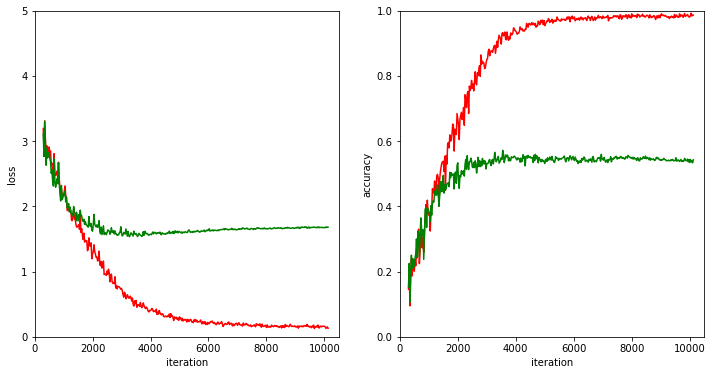

In [7]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,10500)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,10500)
acc_graph.set_ylim(0,1)

plt.show() 

### Saving the top 5 models

In [8]:
saved_models

[{'current_model': PetCNN6(
    (conv1): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
      (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv3): Sequential(
      (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv4): Sequential(
      (0): Dropout2d(p=0.1, inplace=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), 

In [9]:
def save_model(n):
    """
    n is the index of the model in the list saved_models. We'll have filenames that tell you the epoch, for example, B2_3675.pt
    """
    
    torch.save(saved_models[n]['current_model'].state_dict(),'models/B2/B2_' + str(saved_models[n]['current_iter']) + '.pt')

In [10]:
for n in range(5):
    save_model(n)

In [12]:
modelt = PetCNN6()                         # we only saved the model's saved parameters earlier, so we need to instantiate the model class again, and then load the saved parameters
model.load_state_dict(torch.load('models/B2/B2_3275.pt'))
model.eval()

valid_e = next(iter(valid_loader))
valid_o = model(valid_e[0].float())
valid_loss = loss_function(valid_o,valid_e[1])
valid_accuracy = (torch.max(valid_o,1)[1]==valid_e[1]).sum()/len(valid)

print('validation loss:{}'.format(valid_loss))
print('validation accuracy:{}'.format(valid_accuracy))

validation loss:1.5342861413955688
validation accuracy:0.565625011920929


Seems to work fine.

### Test set performance

In [4]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)     
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)   
        
        return out
    

model = PetCNN6()
loss_function = nn.NLLLoss()

In [5]:
path_to_models = 'models/B2/'

for mod in os.listdir(path_to_models):
    modelt = PetCNN6()
    modelt.load_state_dict(torch.load(path_to_models+mod))
    modelt.eval()
    
    test_entire = next(iter(test_loader))
    test_out = modelt(test_entire[0].float())
    test_loss = loss_function(test_out,test_entire[1])
    test_accuracy = (torch.max(test_out,1)[1]==test_entire[1]).sum()/len(test)
    
    print('Model:'+os.path.splitext(mod)[0]) 
    print('Test loss:{}'.format(test_loss))
    print('Test accuracy:{}'.format(test_accuracy))
    print()

Model:B2_6950
Test loss:1.8877160549163818
Test accuracy:0.5082266926765442

Model:B2_4675
Test loss:1.833278775215149
Test accuracy:0.5191956162452698

Model:B2_3575
Test loss:1.7864322662353516
Test accuracy:0.4972577691078186

Model:B2_3275
Test loss:1.8040095567703247
Test accuracy:0.4771480858325958

Model:B2_3550
Test loss:1.795267105102539
Test accuracy:0.4972577691078186



### Confusion matrix on test set performance

We'll plot the confusion matrix for the test set performance of model B2_4675

In [6]:
test_annot_df = pd.read_csv('annotations_aug/annotations_test_B2.csv')

cat_class_ids = {}    # intended to be dictionaries with class_id: breed name as elements 
dog_class_ids = {}

for i in range(len(test_annot_df)):
    species_id = test_annot_df.iloc[i,3]
    class_id = test_annot_df.iloc[i,2]
    pet_label = test_annot_df.iloc[i,1]
    
    if (class_id not in cat_class_ids) and (class_id not in dog_class_ids):
        if species_id == 1:
            cat_class_ids[class_id] = pet_label
        elif species_id == 2:
            dog_class_ids[class_id] = pet_label
            
class_ids = [*cat_class_ids] + [*dog_class_ids]
pet_labels = list(cat_class_ids.values()) + list(dog_class_ids.values())

In [7]:
modelt = PetCNN6()
modelt.load_state_dict(torch.load(path_to_models+'B2_4675.pt'))
modelt.eval()
    
test_entire = next(iter(test_loader))
test_out = modelt(test_entire[0].float())

pred = torch.max(test_out,1)[1].numpy()
pred_true = test_entire[1].numpy()

In [10]:
cf_mat = confusion_matrix(pred_true,pred,labels=class_ids,normalize='true')
cf_df = pd.DataFrame(cf_mat,index=pet_labels, columns=pet_labels)          

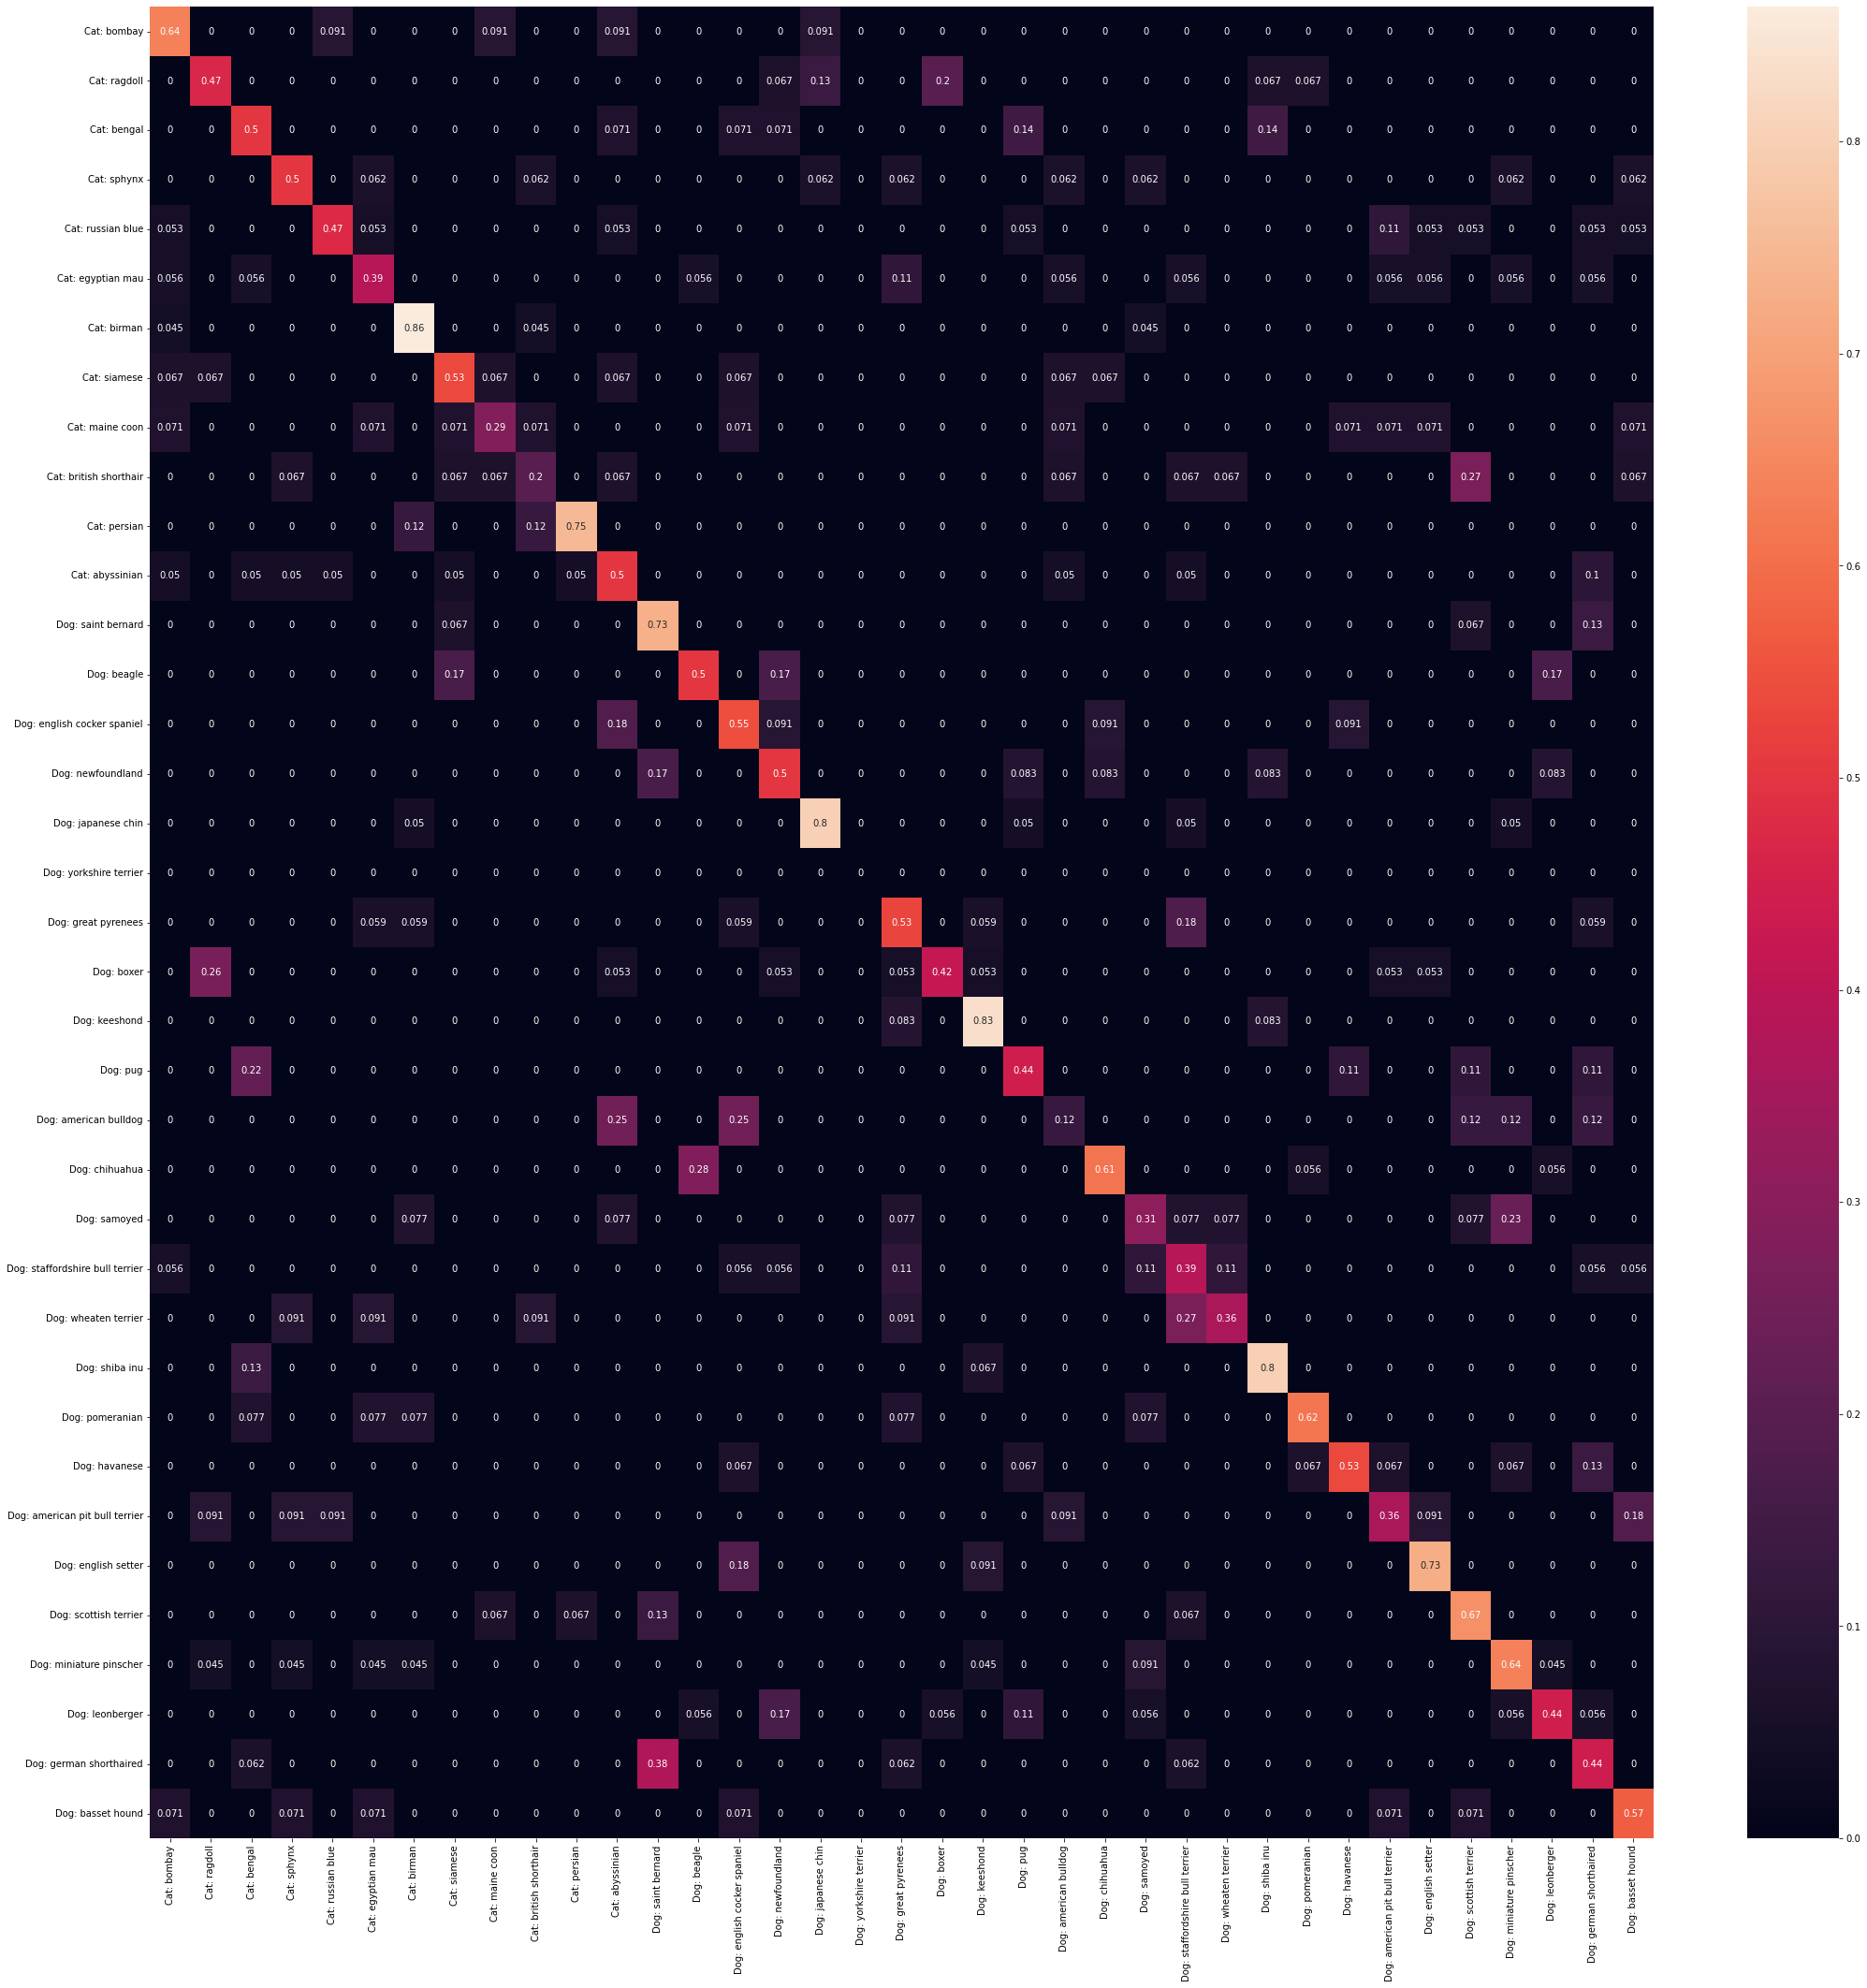

In [12]:
plt.figure(figsize=(36,36))
sns.heatmap(cf_df,annot=True)
plt.savefig('models/B2/cf_matrix_B2_4675.jpg')
plt.show()
